In [110]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/house-prices-advanced-regression-techniques/train.csv
/kaggle/input/house-prices-advanced-regression-techniques/data_description.txt
/kaggle/input/house-prices-advanced-regression-techniques/test.csv
/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv


# Reading the data

Firstly, I will start by creating a function to read the data from the files, to simplify the process. I used it before creating my pipelines, so I also added a parameter which allowed given columns to be dropped from the resulting dataframe.

In [111]:
# Load data from the csv file, droping columns if provided
def load_data(filename:str, columns:'list of strings' = None):
    result = pd.read_csv(filename)
    if columns is not None and len(columns) > 1:
        return result.drop(columns=columns)
    return result

# Brief Data Analysis

I will also define another function, used for quickly analysing dataframes, making use of the following three existing methods, from ```pandas.DataFrame```:

  * ```head``` - to display the first 5 rows of the dataframe, useful for a quick glance
  * ```info``` - to check out the available features, their types and the amount of null/NaN values each has
  * ```describe``` - to have a quick statistical analysis of the dataframe, in order to get an initial idea about it

In [112]:
# Print a brief, quick analysis of a dataframe to gain insight
def quick_analysis(data_frame:pd.DataFrame):
    print('\nAnalysis of dataframe:')
    print(data_frame.head())
    print(data_frame.info())
    print(data_frame.describe())

Finally, it is time to read the data, run our quick analysis and plot a histogram for the label:


Analysis of dataframe:
   Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL         65.0     8450   Pave   NaN      Reg   
1   2          20       RL         80.0     9600   Pave   NaN      Reg   
2   3          60       RL         68.0    11250   Pave   NaN      IR1   
3   4          70       RL         60.0     9550   Pave   NaN      IR1   
4   5          60       RL         84.0    14260   Pave   NaN      IR1   

  LandContour Utilities  ... PoolArea PoolQC Fence MiscFeature MiscVal MoSold  \
0         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
1         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      5   
2         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      9   
3         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
4         Lvl    AllPub  ...        0    NaN   NaN         NaN       0     12   

  YrSold  SaleType  SaleCondition  SalePrice

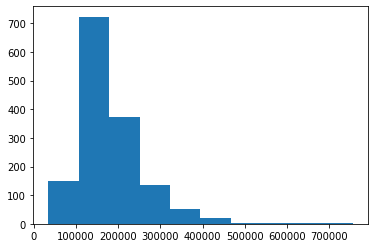

In [113]:
from matplotlib import pyplot as plt

%matplotlib inline

raw_data = load_data('/kaggle/input/house-prices-advanced-regression-techniques/train.csv')
quick_analysis(raw_data)

plt.hist(raw_data['SalePrice'])
plt.show()

Let's start with the histogram. We can clearly see that the data is skewed right. The highest frequency is around 200k, followed by 300k. The few houses that cost more than 4000k seem to be exceptions from the rule. I will still keep them in mind, but maybe some algorithm should be run to check anomalies/outliers and give a more clear indication.

From the quick analysis, we can see a clue that some features (i.e.: ```Alley```, ```PoolQC``` or ```Fence```) could be useless. In regards to the others, nothing out of the ordinary at a first glance at the output of ```head```.

This conclusion is confirmed by looking futher on, at the output of ```info```, which shows us that:
  * **Alley:** *only 91 values*, the rest are null; clearly this one will be of no use
  * **PoolQC:** this one has *just 7 non-null values*! If there were any doubts in regards to the previous feature, there should be none towards this one's usefulness
  * **Fence:** 281 values that we could use; still way lower than the most, which have 1460 values
  * **MiscFeature:** 54 values; once again, we can safely eliminate this feature from our model
  * **FireplaceQu:** this one has a lot more values, 770 to be exact; maybe it could be engineered in a way which would give it importance, but both due to its low amount of values, as well as a common sense intuition, we can safely assume it is useless
  * **LotFrontage:** since it has 1201 values, for the time being we can keep it, in hopes that after the use of an imputer it will have meaning to the model
  * **GarageType:** with 1379 values, it is feasible to keep it and use an imputer to fill in the blanks
  * **GarageYrBlt:** with 1379 values, we should do the same to it
  * **GarageFinish:** with 1379 values, again the treatment will be the same

In [114]:
non_numeric_cols = raw_data.loc[:, raw_data.dtypes == object]

for col in non_numeric_cols.columns:
    print(non_numeric_cols[col].value_counts())

RL         1151
RM          218
FV           65
RH           16
C (all)      10
Name: MSZoning, dtype: int64
Pave    1454
Grvl       6
Name: Street, dtype: int64
Grvl    50
Pave    41
Name: Alley, dtype: int64
Reg    925
IR1    484
IR2     41
IR3     10
Name: LotShape, dtype: int64
Lvl    1311
Bnk      63
HLS      50
Low      36
Name: LandContour, dtype: int64
AllPub    1459
NoSeWa       1
Name: Utilities, dtype: int64
Inside     1052
Corner      263
CulDSac      94
FR2          47
FR3           4
Name: LotConfig, dtype: int64
Gtl    1382
Mod      65
Sev      13
Name: LandSlope, dtype: int64
NAmes      225
CollgCr    150
OldTown    113
Edwards    100
Somerst     86
Gilbert     79
NridgHt     77
Sawyer      74
NWAmes      73
SawyerW     59
BrkSide     58
Crawfor     51
Mitchel     49
NoRidge     41
Timber      38
IDOTRR      37
ClearCr     28
SWISU       25
StoneBr     25
Blmngtn     17
MeadowV     17
BrDale      16
Veenker     11
NPkVill      9
Blueste      2
Name: Neighborhood, dtype:

You could make more sense of the data by reading the ```data_description.txt file```, since I will not go in to greate detail regarding the individual meaning of each feature/category.

I eliminated some based on my common knowledge on houses/buying a house, since I would not give them much importance (which was later confirmed when checking each feature's importance in the model).

# Feature Engineering
## Initial thoughts and approaches

At this point, we should start and brainstorm combinations of those features that we think might impact the sale price of a house. 

Since some features could be more strongly correlated than one would think, we should quickly check the correlation matrix of our dataset.

In [115]:
corr_matrix = raw_data.corr()
sale_correl = corr_matrix['SalePrice'].sort_values(ascending=False)
print(sale_correl)

SalePrice        1.000000
OverallQual      0.790982
GrLivArea        0.708624
GarageCars       0.640409
GarageArea       0.623431
TotalBsmtSF      0.613581
1stFlrSF         0.605852
FullBath         0.560664
TotRmsAbvGrd     0.533723
YearBuilt        0.522897
YearRemodAdd     0.507101
GarageYrBlt      0.486362
MasVnrArea       0.477493
Fireplaces       0.466929
BsmtFinSF1       0.386420
LotFrontage      0.351799
WoodDeckSF       0.324413
2ndFlrSF         0.319334
OpenPorchSF      0.315856
HalfBath         0.284108
LotArea          0.263843
BsmtFullBath     0.227122
BsmtUnfSF        0.214479
BedroomAbvGr     0.168213
ScreenPorch      0.111447
PoolArea         0.092404
MoSold           0.046432
3SsnPorch        0.044584
BsmtFinSF2      -0.011378
BsmtHalfBath    -0.016844
MiscVal         -0.021190
Id              -0.021917
LowQualFinSF    -0.025606
YrSold          -0.028923
OverallCond     -0.077856
MSSubClass      -0.084284
EnclosedPorch   -0.128578
KitchenAbvGr    -0.135907
Name: SalePr

Looking at the correlation coefficients for each feature, I thought maybe I could engineer something using the *unfinished basement surface/percentage*. That seems to be a dead end, since anything I came up with had its Pearson's *r* less than 0.1.

Next I decied to see if I could create a more comprehensive "grade" for a house, using ```OverallCond``` and ```OverallQual```:

In [116]:
raw_data['Grade'] = raw_data['OverallQual'] / raw_data['OverallCond']

Next, why not focus on the columns related to the year the house was built, remodelled and sold in. Concretely, we can find the age of the house and the remodelling it suffered, at the time of the sell.

In [117]:
raw_data['Age'] = raw_data['YrSold'] - raw_data['YearBuilt']
raw_data['RemodAge'] = raw_data['YrSold'] - raw_data['YearRemodAdd']

I also thought maybe the total surface of the house could impact significantly its price, this adding the following feature:

In [118]:
raw_data['TotalSF'] = raw_data['TotalBsmtSF'] + raw_data['1stFlrSF'] + raw_data['2ndFlrSF']

Finally let's remake the correlation matrix, to see the influence our new features exert onto the sale price.

In [119]:
corr_matrix = raw_data.corr()
sale_correl = corr_matrix['SalePrice'].sort_values(ascending=False)
print(sale_correl)

SalePrice        1.000000
OverallQual      0.790982
TotalSF          0.782260
GrLivArea        0.708624
GarageCars       0.640409
Grade            0.626063
GarageArea       0.623431
TotalBsmtSF      0.613581
1stFlrSF         0.605852
FullBath         0.560664
TotRmsAbvGrd     0.533723
YearBuilt        0.522897
YearRemodAdd     0.507101
GarageYrBlt      0.486362
MasVnrArea       0.477493
Fireplaces       0.466929
BsmtFinSF1       0.386420
LotFrontage      0.351799
WoodDeckSF       0.324413
2ndFlrSF         0.319334
OpenPorchSF      0.315856
HalfBath         0.284108
LotArea          0.263843
BsmtFullBath     0.227122
BsmtUnfSF        0.214479
BedroomAbvGr     0.168213
ScreenPorch      0.111447
PoolArea         0.092404
MoSold           0.046432
3SsnPorch        0.044584
BsmtFinSF2      -0.011378
BsmtHalfBath    -0.016844
MiscVal         -0.021190
Id              -0.021917
LowQualFinSF    -0.025606
YrSold          -0.028923
OverallCond     -0.077856
MSSubClass      -0.084284
EnclosedPorc

As we can see all our features are moderately correlated to the sale price, with ```Age``` and ```RemodAge``` actually being more strongly correlated to it than either of their components. Granted that the difference is not that big.

The ```Grade``` seems to be a good indicator as well, but the ```TotalSF``` is the clear winner, being strongly correlated to the price (compared to the aforementioned at least).

Now let us also check the correlation between each of the new features with regards to their components, in order to prevent "duplicates".

In [120]:
age_correl = corr_matrix['Age'].sort_values(ascending=False)
print('Age correlations:', age_correl, '\n')

remod_age_correl = corr_matrix['RemodAge'].sort_values(ascending=False)
print('RemodAge correlations:', remod_age_correl, '\n')

grade_correl = corr_matrix['Grade'].sort_values(ascending=False)
print('Grade correlations:', grade_correl, '\n')

totalsf_correl = corr_matrix['TotalSF'].sort_values(ascending=False)
print('TotalSF correlations:', totalsf_correl, '\n')

Age correlations: Age              1.000000
RemodAge         0.594195
EnclosedPorch    0.386228
OverallCond      0.377325
LowQualFinSF     0.182228
KitchenAbvGr     0.175918
BedroomAbvGr     0.068960
YrSold           0.057500
ScreenPorch      0.050755
BsmtFinSF2       0.050422
BsmtHalfBath     0.036060
MiscVal          0.034545
Id               0.012724
PoolArea        -0.007563
2ndFlrSF        -0.011552
LotArea         -0.014832
MoSold          -0.018777
MSSubClass      -0.028746
3SsnPorch       -0.030487
TotRmsAbvGrd    -0.096955
LotFrontage     -0.122848
Fireplaces      -0.148544
BsmtUnfSF       -0.150619
BsmtFullBath    -0.184362
OpenPorchSF     -0.190921
GrLivArea       -0.200302
WoodDeckSF      -0.223551
HalfBath        -0.242728
BsmtFinSF1      -0.248483
1stFlrSF        -0.282143
MasVnrArea      -0.315562
TotalSF         -0.347892
TotalBsmtSF     -0.391498
FullBath        -0.468403
GarageArea      -0.479408
SalePrice       -0.523350
GarageCars      -0.538727
OverallQual     -0.5

We can see a strong negative correlation between ```Age``` and ```YearBuilt```, as well as between ```RemodeAge``` and ```YearRemodAdd```. Thus, we should keep either or, from each pair, since they are so similar.

While ```Grade``` is also pretty correlated with its components, I will keep it for now, since it is nowhere near as similar to them, as the previous features were.

```TotalSF``` seems to be strongly correlated to 3 other features (excluding the sale price), 2 of which are its components. The third is most likely correlated to the ```1stFlrSF``` feature and thus I will ignore it for now. We could still keep this feature, since it also takes into account the ```2ndFlrSF```.

After checking the other low correlation features, with regards to the sale price, I found no other combinations I could make or that had a good correlation (>0.5).

# Feature Selection

In order to see if more can be found out from our data, with hopes to help in feature selection, I will define the following function:

In [121]:
from matplotlib import ticker as tick

# Plot correlations
def corr_plot(data :pd.DataFrame, feature :str, threshold=0.5, plot_type :str = 'scatter', y_lower_scale=True, same_fig=True, fig_size=(3, 4)):
    fig = plt.figure()
    corr_matrix = data.corr()
    alpha = 0.3
    i = 1
    for feat in corr_matrix.columns:
        if abs(corr_matrix[feat][feature]) > threshold and feat != feature:
            if same_fig == True:
                ax = fig.add_subplot(fig_size[0], fig_size[1], i)
                if plot_type == 'scatter':
                    ax.scatter(x=feat, y=feature, data=data, alpha=alpha)
                elif plot_type == 'hist':
                    ax.hist(x=feat, data=data)
                ax.set_xlabel(feat)
                if y_lower_scale == True:
                    ax.yaxis.set_major_formatter(tick.FormatStrFormatter('%.e'))
                plt.yticks(rotation=45)
                i = i + 1
            else:
                if plot_type == 'scatter':
                    plt.scatter(x=feat, y=feature, data=data, alpha=alpha)
                elif plot_type == 'hist':
                    plt.hist(x=feat, data=data)
                plt.xlabel(feat)
                plt.show()

    if same_fig == True:
        fig.tight_layout()
        plt.show()

A quick look at the scatter plots for the price:

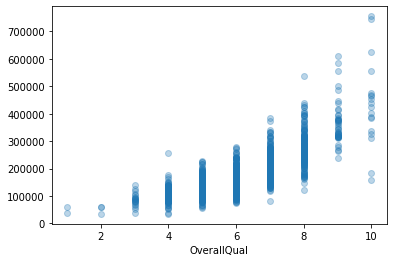

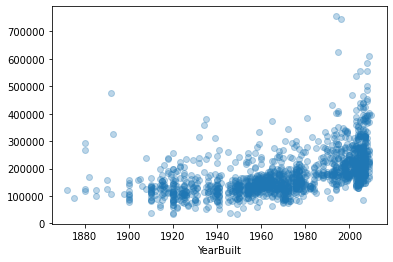

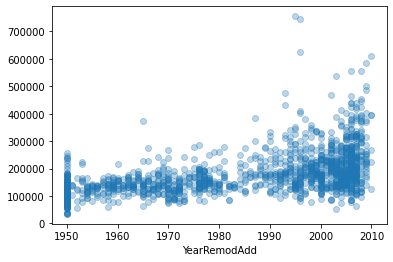

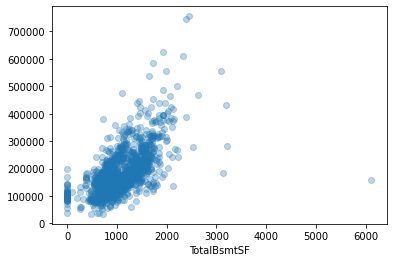

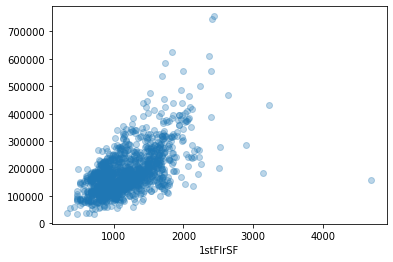

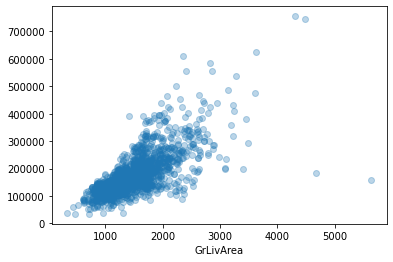

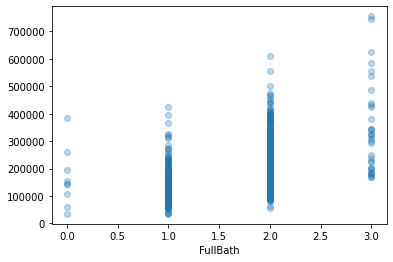

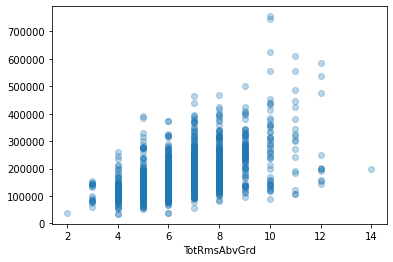

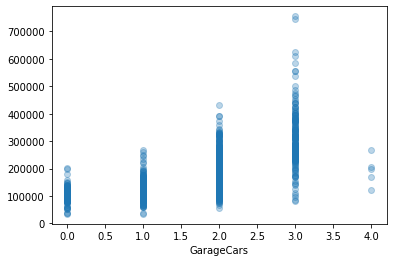

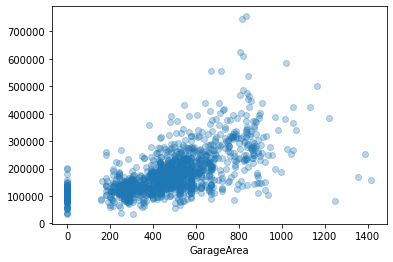

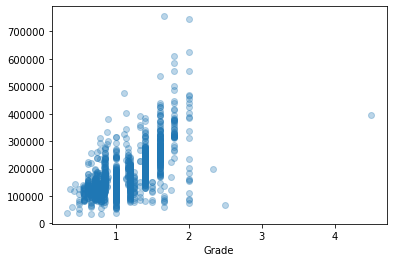

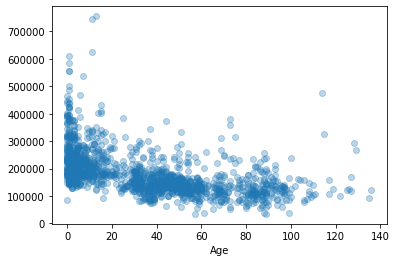

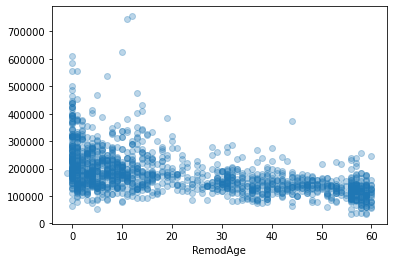

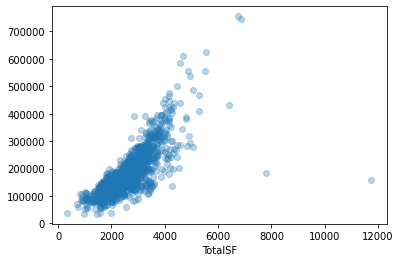

In [122]:
corr_plot(raw_data, 'SalePrice', y_lower_scale=False, same_fig=False)

Doing the same but with histograms:

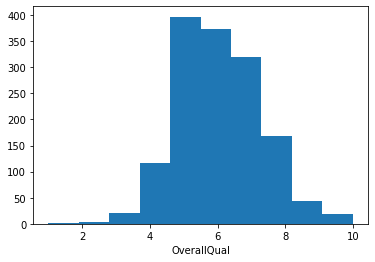

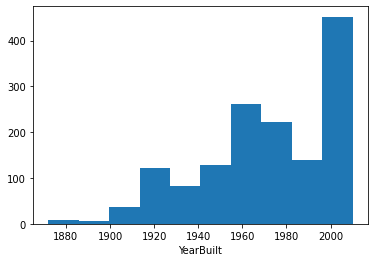

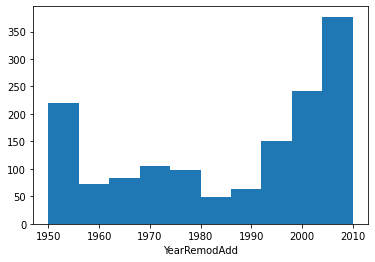

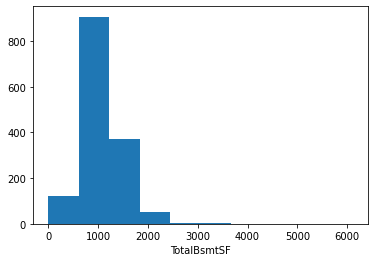

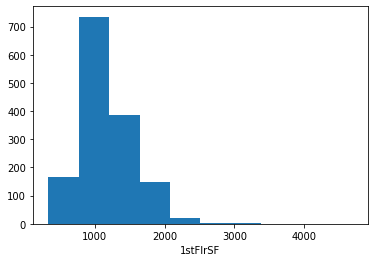

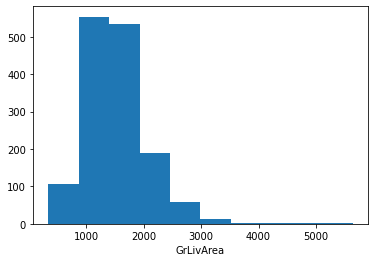

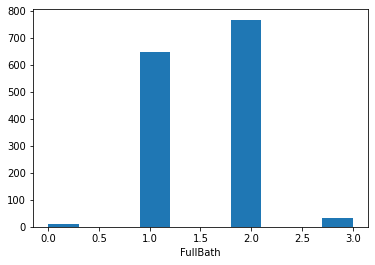

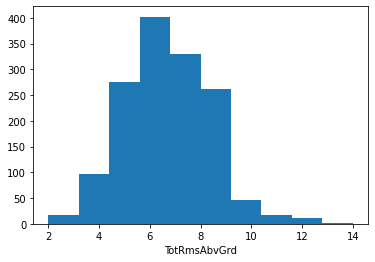

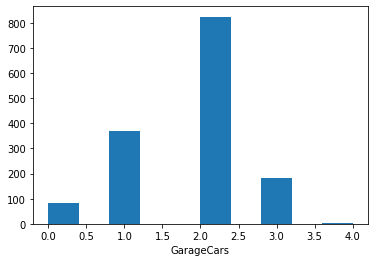

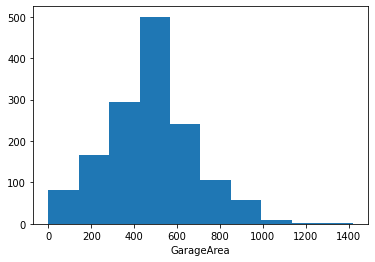

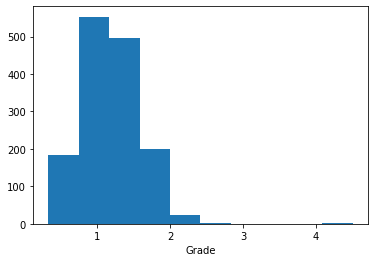

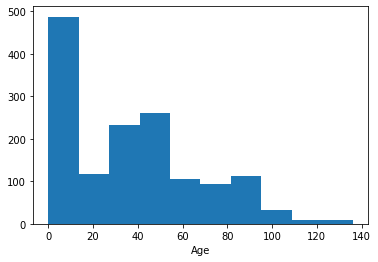

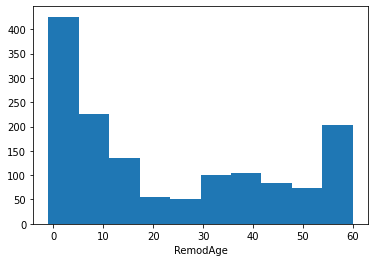

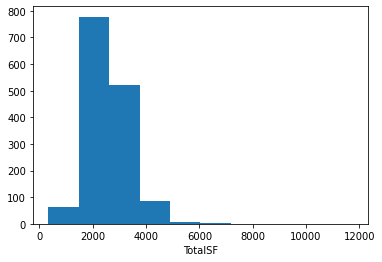

In [123]:
corr_plot(raw_data, 'SalePrice', plot_type='hist', y_lower_scale=False, same_fig=False)

We can see that most of the features are skewed right, same as with the sale price, with some of the others skewed left, indicative of their positive, negative respectively correlation. 

We can see some clear outliers now, with the scatter plot, as well as with the histograms, giving us a more complete view of how our data is distributed.

I will not do this in the current model, but one could test different strategies to deal with the clear outliers in our data.

The ```GarageArea``` seems to have a slight upwards trend, but the data is almost entirely concentrated around one spot. Thus, I do not think it will provide great use for predicting the sale price.

The surfaces seem to have the same distribution and the same trend, with our engineered feature, ```TotalSF``` being less disperse. We might want to only keep that one in our model.

## Pipelines and transformers

In order to make it easier to select, drop and create features, as well as deal with missing values and scaling, I will create *pipelines*, which will contain *custom transformers*.

Let's start with the transformers. They are quite basic, one drops given columns, one only keeps specified columns and another creates a new feature from multiple others, given an operation to perfom on the later. I will also add some other parameters, which will allow for the result to be either a ```numpy``` array or a ```pandas``` dataframe.

In [124]:
from sklearn.base import BaseEstimator, TransformerMixin
import numpy as np


class FeatureCreator(BaseEstimator, TransformerMixin):
    def __init__(self, features :'list of strings', operation, as_dataframe :bool = False, feat_name :str = 'NewFeature'):
        self.features = features
        self.operation = operation
        self.as_dataframe = as_dataframe
        self.feat_name = feat_name

    def fit(self, X, y = None):
        return self

    def transform(self, X, y = None):
        no_feat = len(self.features)
        prev_feat = self.features[0]
        for i in range(1, no_feat):
            new_feature = self.operation(X[prev_feat], X[self.features[i]])
            prev_feat = self.features[i]

        if self.as_dataframe:
            X[self.feat_name] = new_feature
            return X

        return np.c_[X, new_feature]


class FeatureDropper(BaseEstimator, TransformerMixin):
    def __init__(self, features, as_dataframe :bool = False):
        self.features = features
        self.as_dataframe = as_dataframe

    def fit(self, X, y = None):
        return self

    def transform(self, X, y = None):
        if self.as_dataframe == True:
            return X.drop(columns=self.features)
        return np.c_[X.drop(columns=self.features)]


class FeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, features, as_dataframe :bool = False):
        self.features = features
        self.as_dataframe = as_dataframe

    def fit(self, X, y = None):
        return self

    def transform(self, X, y = None):
        if self.as_dataframe == True:
            return X[self.features]
        return np.c_[X[self.features]]


class CategoricalImputer(BaseEstimator, TransformerMixin):

    def __init__(self, strategy :str = 'most_frequent', value :str = None):
        self.strategy = strategy
        self.value = value
        
    def fit(self, X, y=None):
        if self.strategy == 'most_frequent':
            self.fill = pd.Series([X[col].mode()[0] for col in X], index=X.columns)
        elif self.strategy == 'nan_to_none':
            self.fill = pd.Series(['None' for col in X], index=X.columns)
        elif self.strategy == 'custom_val' and self.value is not None:
            self.fill = pd.Series([self.value for col in X], index=X.columns)
            
        return self

    def transform(self, X, y=None):
        return X.fillna(self.fill)
   


Before anything else, let's define the columns we want to keep, initially. We shall also separate them into numerical and categorical features.

Since both the year and month during which a house was sold are actually categorical features, we should also convert them. The same need to be done to the ```MSZoning``` and ```OverallCond``` features.

In [125]:
raw_data['YrSold_C'] = raw_data['YrSold'].copy().astype(str)
raw_data['MoSold'] = raw_data['MoSold'].astype(str)
raw_data['MSZoning'] = raw_data['MSZoning'].astype(str)
raw_data['OverallCond_C'] = raw_data['OverallCond'].copy().astype(str)

num_cols = [
    'OverallQual', 
    'OverallCond', 
    'YearBuilt', 
    'YearRemodAdd', 
    'TotalBsmtSF', 
    '1stFlrSF', 
    '2ndFlrSF', 
    'GarageCars',
    'GarageArea',
    'FullBath',
    'YrSold', 
] 
cat_cols = [
    'MSZoning', 
    'Street', 
    'Utilities', 
    'Neighborhood', 
    'ExterQual', 
    'ExterCond', 
    'BsmtQual', 
    'BsmtCond', 
    'Heating', 
    'CentralAir', 
    'PavedDrive', 
    'SaleType', 
    'SaleCondition',
    'YrSold_C', 
    'MoSold',
    'OverallCond_C',
]

We cannot know if the test data will have all categories that each non-numeric feature can take, thus we should also store them separately, for later encoding:

In [126]:
cat_cols_categs = [raw_data[col].unique() for col in cat_cols]
cat_cols_categs

[array(['RL', 'RM', 'C (all)', 'FV', 'RH'], dtype=object),
 array(['Pave', 'Grvl'], dtype=object),
 array(['AllPub', 'NoSeWa'], dtype=object),
 array(['CollgCr', 'Veenker', 'Crawfor', 'NoRidge', 'Mitchel', 'Somerst',
        'NWAmes', 'OldTown', 'BrkSide', 'Sawyer', 'NridgHt', 'NAmes',
        'SawyerW', 'IDOTRR', 'MeadowV', 'Edwards', 'Timber', 'Gilbert',
        'StoneBr', 'ClearCr', 'NPkVill', 'Blmngtn', 'BrDale', 'SWISU',
        'Blueste'], dtype=object),
 array(['Gd', 'TA', 'Ex', 'Fa'], dtype=object),
 array(['TA', 'Gd', 'Fa', 'Po', 'Ex'], dtype=object),
 array(['Gd', 'TA', 'Ex', nan, 'Fa'], dtype=object),
 array(['TA', 'Gd', nan, 'Fa', 'Po'], dtype=object),
 array(['GasA', 'GasW', 'Grav', 'Wall', 'OthW', 'Floor'], dtype=object),
 array(['Y', 'N'], dtype=object),
 array(['Y', 'N', 'P'], dtype=object),
 array(['WD', 'New', 'COD', 'ConLD', 'ConLI', 'CWD', 'ConLw', 'Con', 'Oth'],
       dtype=object),
 array(['Normal', 'Abnorml', 'Partial', 'AdjLand', 'Alloca', 'Family'],
       dty

Finally, we can now define pipelines for numerical and categorical columns and bring the results together using the ```FeatureUnion``` class provided by ```sklearn```.

I opted for the *mean* imputer strategy for numerical features an the *most frequent* stategy for categorical features, as they seemed to be the most sensible ones to use, based on the density and distribution seen for each feature in the previous plots.

Finally, for numerical features, *standard scaling* seems like a good scaling option, while for categorical features the *one-hot encoding* would be a competent option.

In [127]:
from sklearn.pipeline import Pipeline, FeatureUnion 
from sklearn.preprocessing import OneHotEncoder, StandardScaler, RobustScaler
from sklearn.impute import SimpleImputer as Imputer

num_pipeline = Pipeline([
    ('feat_sel', FeatureSelector(num_cols, True)),
    ('grade', FeatureCreator(['OverallCond', 'OverallQual'], lambda x, y: x / y, as_dataframe=True, feat_name='Grade')),
    ('age', FeatureCreator(['YrSold', 'YearBuilt'], lambda x,y: x - y, as_dataframe=True, feat_name='Age')),
    ('remod_age', FeatureCreator(['YrSold', 'YearRemodAdd'], lambda x,y: x - y, as_dataframe=True, feat_name='RemodAge')),
    ('total_sf', FeatureCreator(['TotalBsmtSF', '1stFlrSF', '2ndFlrSF'], lambda x,y: x + y, as_dataframe=True, feat_name='TotalSF')),
    ('drop_cat_feat', FeatureDropper(['YrSold', 'OverallCond'], as_dataframe=True)),
    ('imputer_mean', Imputer(strategy='mean')),
    ('robust_scalar', RobustScaler())
]) 

cat_pipeline = Pipeline([
    ('feat_sel', FeatureSelector(cat_cols, True)),
    ('imputer_most_frequent', CategoricalImputer()),
    ('encode', OneHotEncoder(categories=cat_cols_categs, sparse=False)),
])
feat_union = FeatureUnion(transformer_list=[
    ('num_features', num_pipeline),
    ('cat_features', cat_pipeline),
])

We can now create the train features and labels, by simply doing the folowing:

In [128]:
train_labels = raw_data['SalePrice'].copy()
train_feat = feat_union.fit_transform(raw_data)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


# Model evaluation

To evaluate the performance of the models we will test, a good option if to use the **RMSE** in combination with **cross-validation**. To enable easier evaluation and hyperparameter tuning, we shall also use the **grid search cross-validation** algorithm.

We shall test the following algorithms:
  * **Linear regression:** a classical, common algorithm; probably will not yield great results, but no reason not to test it
  * **Decision trees:** a better alternative, in some cases; again, by itself will probabily not give greate results, from what I know, decission trees being easily overfit
  * **Random forest:** a much more useful alternative to *decision trees*, since it makes use of ensemble learning, which in turn is usually a better alternative to using only 1 model
  * **XGBoost random forest regressor:** a gradient boosting alternative to the previously mentioned random forest models
  * **Support vector machine:** a completely different approach from the previous models; maybe it will surprize us
  * **ElasticNet regression:** another commonly used linear model, that could maybe yield good results
  
The grid search cross-validation algorithm is found in ```sklearn```, just like all others, with the exception of ```XGBoost``` ones. We can also import the **MSE** function, in case we will need it later on:

In [129]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score, GridSearchCV

Finally, we can start testing the models:

In [130]:
from sklearn.linear_model import LinearRegression


lin_reg = LinearRegression()
grid_search = GridSearchCV(lin_reg, [{}], cv=5, scoring='neg_mean_squared_error')
grid_search.fit(train_feat, train_labels)
print('Linear regression best hyperparameters:')
print(grid_search.best_params_, np.sqrt(-grid_search.best_score_))

final_lr_model = grid_search.best_estimator_

Linear regression best hyperparameters:
{} 1584317460659582.5


As expected, *linear regression* is not a suitable algorithm for our problem.

In [131]:
from sklearn.tree import DecisionTreeRegressor


hyperparams_vals = [
    {'max_features': [6, 10, 12, 16, 18, 20, 24]},
]
    
dt_reg = DecisionTreeRegressor(random_state=42)
grid_search = GridSearchCV(dt_reg, hyperparams_vals, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(train_feat, train_labels)
print('Decision tree best hyperparameters:')
print(grid_search.best_params_, np.sqrt(-grid_search.best_score_))

final_dt_model = grid_search.best_estimator_

Decision tree best hyperparameters:
{'max_features': 18} 44711.19805241402


*Decision trees* seem like a better alternative to the *linear regression* model, but we probably can do better with *random forests*. 

In [132]:
from sklearn.ensemble import RandomForestRegressor


hyperparams_vals = [
    {'n_estimators': [200, 225, 250], 'max_features': [16, 24, 30]},
    {'bootstrap': [False], 'n_estimators': [220, 225], 'max_features': [24, 28]},
]
    
forest_reg = RandomForestRegressor(n_jobs=-1, random_state=42)
grid_search = GridSearchCV(forest_reg, hyperparams_vals, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(train_feat, train_labels)
print('Random forest best hyperparameters:')
print(grid_search.best_params_, np.sqrt(-grid_search.best_score_))

final_rf_model = grid_search.best_estimator_

Random forest best hyperparameters:
{'bootstrap': False, 'max_features': 24, 'n_estimators': 220} 29825.048870918858


```SKLearn```'s *random forest* algorithm seems to be a good choice so far, having the best score. Let's compare it with ```XGBoost```'s algorithm:

In [133]:
from xgboost import XGBRegressor


hyperparams_vals = [
    {'n_estimators': [450, 500, 750], 'max_features': [2, 4, 8], 'max_depth': [3, 4, None]},
]
    
xgbr_reg = XGBRegressor(learning_rate=0.05, n_threads=-1, random_state=42)
grid_search = GridSearchCV(xgbr_reg, hyperparams_vals, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(train_feat, train_labels)
print('XGBoost regressor best hyperparameters:')
print(grid_search.best_params_, np.sqrt(-grid_search.best_score_))

final_xgb_model = grid_search.best_estimator_

XGBoost regressor best hyperparameters:
{'max_depth': 3, 'max_features': 2, 'n_estimators': 450} 27991.09490887587


Seems like the last two are quite similar, but ```XGBoost```'s *random forest* is the best performer, even if by a slight margin.

Lets quickly analize the *support vector machine* as well:

In [134]:
from sklearn.svm import SVR


hyperparams_vals = [
    {'kernel': ['linear', 'sigmoid', 'rbf'], 'gamma': ['auto', 'scale']},
    {'kernel': ['poly'], 'gamma': ['auto', 'scale'], 'degree': [3, 4, 5]},
]
    
svm_reg = SVR()
grid_search = GridSearchCV(svm_reg, hyperparams_vals, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(train_feat, train_labels)
print('Support vector machine best hyperparameters:')
print(grid_search.best_params_, np.sqrt(-grid_search.best_score_))

final_svm_model = grid_search.best_estimator_

Support vector machine best hyperparameters:
{'gamma': 'auto', 'kernel': 'linear'} 78710.58399838713


Taking a look at another linear model, the *ElasticNet regression* yields the following results:

In [135]:
from sklearn.linear_model import ElasticNet


hyperparams_vals = [
    {'alpha': [0.0005, 0.005, 0.05, 0.2], 'l1_ratio': [0.1, 0.25, 0.75, 0.9]},
]

enet_reg = ElasticNet(max_iter=100000000, tol=0.001)
grid_search = GridSearchCV(enet_reg, hyperparams_vals, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(train_feat, train_labels)
print('ElasticNet best hyperparameters:')
print(grid_search.best_params_, np.sqrt(-grid_search.best_score_))

final_enet_model = grid_search.best_estimator_

ElasticNet best hyperparameters:
{'alpha': 0.05, 'l1_ratio': 0.9} 34209.09893754547


The clear winner is ```XGBoost```'s *random forest* model. We should also take into cosideration ```SKLearn```'s version of the algorithm as it was close to the former. I doesn't seem like *ElasticNet* has a low enough error to consider it when combining the algorithms.

Now it is time to analize the feature importance of our best model:

In [136]:
rf_feat_imp = final_rf_model.feature_importances_
xgb_feat_imp = final_xgb_model.feature_importances_

other_feat = ['Grade', 'RemodAge', 'TotalSF']
all_features = num_cols.copy()
print(num_cols)
for cat_values in cat_cols_categs.copy():
    all_features.extend(cat_values)
all_features.extend(other_feat.copy())

print('Random forest feature importances:')
for feat in sorted(zip(rf_feat_imp, all_features), reverse=True):
    print(feat)
    
print('\nXGBoost feature importances:')
for feat in zip(xgb_feat_imp, all_features):
    print(feat)

['OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'GarageCars', 'GarageArea', 'FullBath', 'YrSold']
Random forest feature importances:
(0.19054549947291108, 'OverallQual')
(0.12158678140004958, 'RM')
(0.0705290945990372, '2ndFlrSF')
(0.06873316756383636, 'FullBath')
(0.06544229068550177, 'YearRemodAdd')
(0.05552274818690155, 'TotalBsmtSF')
(0.05098931135773153, 'Fa')
(0.04906552166144532, 'OverallCond')
(0.04605914610723966, 'GarageCars')
(0.044551906150082365, '1stFlrSF')
(0.042887447015089286, 'YrSold')
(0.027163493297388475, 'GarageArea')
(0.02430477689046214, 'Fa')
(0.019097478802803772, 'YearBuilt')
(0.01547210468237104, 'RL')
(0.008278298601131924, 'Ex')
(0.007696521987415737, 'Ex')
(0.007209462775668488, nan)
(0.006845816449762955, 'TA')
(0.005017047501570016, 'Somerst')
(0.0035882538269456387, 'FV')
(0.0031641314279504495, 'Gilbert')
(0.0030419723028028657, 'C (all)')
(0.0029120933934786313, 'N')
(0.0027677870824464232, 'Y')
(0.0

Seems like for the most part, the features engineered have a significant importance in predicting the sale price. We should move on with actually predicting the labels for the test data, as I am pleased with the current results.

In [139]:
test_data = load_data('/kaggle/input/house-prices-advanced-regression-techniques/test.csv')
test_data['YrSold_C'] = test_data['YrSold'].copy().astype(str).replace('nan', None)
test_data['MoSold'] = test_data['MoSold'].astype(str).replace('nan', None)
test_data['MSZoning'] = test_data['MSZoning'].astype(str).replace('nan', None)
test_data['OverallCond_C'] = test_data['OverallCond'].copy().astype(str).replace('nan', None)
test_feat = feat_union.transform(test_data)

rf_predictions = final_rf_model.predict(test_feat)
xgb_predictions = final_xgb_model.predict(test_feat)
predictions = rf_predictions * 0.35 + xgb_predictions * 0.65

pred_df = pd.DataFrame()
pred_df['Id'] = test_data['Id']
pred_df['SalePrice'] = predictions.flatten()

print(pred_df)

ValueError: Must specify a fill 'value' or 'method'.